In [1]:
import sys
import os

import pandas as pd
import numpy as np
import loompy
import velocyto as vcy

import matplotlib
import matplotlib.pyplot as plt

import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

2022-02-21 16:34:55,294 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

In [3]:
loom_dir = "../../../data/cellranger/results/velocyto/"

# Crate an analysis object
vlm = vcy.VelocytoLoom(os.path.join(loom_dir, "combined.loom"))


In [10]:
# get cell ids to match loom object
mdata = pd.read_csv("../tables/bcells_mzb1_bg_corrected_metadata.tsv.gz", sep="\t")

new_ids = []
for cell in mdata["new_cell_id"]:
  fields = cell.split("_")
  sample_id = fields[0:(len(fields) - 1)]
  bc = fields[-1] + "x"
  new_id = "_".join(sample_id) + ":" + bc
  new_ids.append(new_id)
  
mdata = mdata.assign(new_id = new_ids)

mdata = mdata[mdata.new_id.isin(list(vlm.ca["CellID"]))]

# reorder cell ids to match loom object
cids =  pd.DataFrame({'new_id' : vlm.ca["CellID"]})
mdata = pd.merge(cids, mdata, how = 'left', on = 'new_id')
mdata = mdata.dropna()

#only keep cells found in seurat data
keep_idx = [x in list(mdata["new_id"]) for x in list(vlm.ca["CellID"])]

vlm.filter_cells(bool_array=keep_idx)

#add cluster annotations
vlm.set_clusters(np.array([str(x) for x in mdata["coarse_clusters"]]))

#add embedding 
vlm.ca["UMAP1"] = np.array(mdata["UMAP_1"])
vlm.ca["UMAP2"] = np.array(mdata["UMAP_2"])
vlm.ts = np.column_stack([vlm.ca["UMAP1"], vlm.ca["UMAP2"]])


In [5]:
vlm.S.shape
int(len(vlm.ca["CellID"]) * 0.025)

38

2022-02-21 16:36:41,812 - DEBUG - Filtering by detection level
2022-02-21 16:36:42,217 - DEBUG - svr_gamma set to 0.02287980475899939
2022-02-21 16:36:42,853 - DEBUG - Filtering by cv vs mean
2022-02-21 16:36:47,768 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-02-21 16:36:47,769 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2022-02-21 16:36:47,770 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
2022-02-21 16:36:47,770 - DEBUG - findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
2022-02-21 16:36:47,771 - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,771 - DEBUG - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,772 - DEBUG - findfont:

2022-02-21 16:36:47,809 - DEBUG - findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,810 - DEBUG - findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal regular normal>) = 10.05
2022-02-21 16:36:47,810 - DEBUG - findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal bold normal>) = 10.335
2022-02-21 16:36:47,811 - DEBUG - findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,812 - DEBUG - findfont: score(<Font 'Luxi Sans' (luxisri.ttf) oblique normal 400 normal>) = 11.05
2022-02-21 16:36:47,812 - DEBUG - findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBI.ttf) oblique normal bold normal>) = 11.335
2022-02-21 16:36:47,813 - DEBUG - findfont: score(<Font 'Serto Mardin' (SyrCOMMardinBold.otf) normal normal bold normal>) = 10.335
2022-02-21 16:36:47,814 - DEBUG - findfont: score(<Font 'Serto Jerusalem Outline' (SyrCOMJerusalemOutline.otf) normal normal 4

2022-02-21 16:36:47,850 - DEBUG - findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,850 - DEBUG - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Ultralight.otf) normal normal ultralight normal>) = 10.335
2022-02-21 16:36:47,851 - DEBUG - findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 4.6863636363636365
2022-02-21 16:36:47,851 - DEBUG - findfont: score(<Font 'Bitstream Vera Sans' (Vera.ttf) normal normal 400 normal>) = 0.9590909090909092
2022-02-21 16:36:47,852 - DEBUG - findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
2022-02-21 16:36:47,852 - DEBUG - findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 700 normal>) = 10.335
2022-02-21 16:36:47,853 - DEBUG - findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
2022-02-21 16:36:47,853 - DEBUG - findfont: score(<Font 'Devanagari MT

2022-02-21 16:36:47,891 - DEBUG - findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,891 - DEBUG - findfont: score(<Font 'Luxi Mono' (luximbi.ttf) oblique normal bold normal>) = 11.335
2022-02-21 16:36:47,892 - DEBUG - findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal book normal>) = 10.05
2022-02-21 16:36:47,892 - DEBUG - findfont: score(<Font 'Luxi Sans' (luxisbi.ttf) oblique normal bold normal>) = 11.335
2022-02-21 16:36:47,893 - DEBUG - findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal semibold normal>) = 10.24
2022-02-21 16:36:47,894 - DEBUG - findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,894 - DEBUG - findfont: score(<Font 'Estrangelo Talada' (SyrCOMTalada.otf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,895 - DEBUG - findfont: score(<Font '.SF NS Symbols' (SFNSSymbols

2022-02-21 16:36:47,936 - DEBUG - findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,936 - DEBUG - findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
2022-02-21 16:36:47,937 - DEBUG - findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335
2022-02-21 16:36:47,937 - DEBUG - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal bold normal>) = 10.335
2022-02-21 16:36:47,938 - DEBUG - findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,938 - DEBUG - findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.05
2022-02-21 16:36:47,939 - DEBUG - findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
2022-02-21 16:36:47,939 - DEBUG - findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) norma

2022-02-21 16:36:47,979 - DEBUG - findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal regular normal>) = 10.05
2022-02-21 16:36:47,979 - DEBUG - findfont: score(<Font 'System Font' (SFNSDisplay-ThinG2.otf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,979 - DEBUG - findfont: score(<Font 'Serto Malankara' (SyrCOMMalankara.otf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,980 - DEBUG - findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,980 - DEBUG - findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
2022-02-21 16:36:47,981 - DEBUG - findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Medium.otf) normal normal medium normal>) = 10.145
2022-02-21 16:36:47,982 - DEBUG - findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
2022-02-21 16:36:47,982 - DEBUG - findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal no

2022-02-21 16:36:48,019 - DEBUG - findfont: score(<Font 'Luxi Serif' (luxirb.ttf) normal normal bold normal>) = 10.335
2022-02-21 16:36:48,020 - DEBUG - findfont: score(<Font 'Futura' (Futura.ttc) normal normal medium normal>) = 10.145
2022-02-21 16:36:48,020 - DEBUG - findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05
2022-02-21 16:36:48,021 - DEBUG - findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:48,022 - DEBUG - findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05
2022-02-21 16:36:48,023 - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal bold normal>) = 10.335
2022-02-21 16:36:48,024 - DEBUG - findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal bold normal>) = 11.335
2022-02-21 16:36:48,025 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=

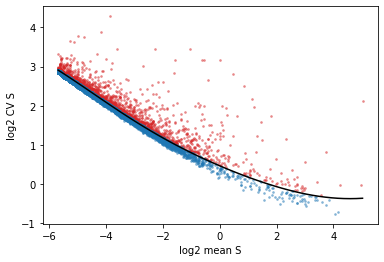

In [6]:
vlm.normalize("S", size=True, log=True)


vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))

vlm.score_detection_levels(min_expr_counts=30,
                           min_cells_express=20)
vlm.filter_genes(by_detection_levels=True)

vlm.score_cv_vs_mean(1500, plot=True, max_expr_avg=35)

vlm.filter_genes(by_cv_vs_mean=True)

vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

vlm.perform_PCA()

vlm.knn_imputation(n_pca_dims=20,
                   k = int(len(vlm.ca["CellID"]) * 0.025),
                   balanced=False,n_jobs=6)
               #    b_sight=1000, b_maxl=1500, n_jobs=6)
vlm.fit_gammas()
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

308.6

In [7]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt",
                             psc=1, n_neighbors= int(vlm.S.shape[1] / 5),
                             knn_random=True, sampled_fraction=0.5)

vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)
vlm.calculate_grid_arrows(smooth = 0.5,
                          steps=(30, 30),
                          n_neighbors=int(vlm.S.shape[1] * 0.10))



2022-02-21 16:48:25,583 - DEBUG - label 0:
    value = arg(0, name=value)               ['value']
    $0.1 = global(np: <module 'numpy' from '/miniconda3/lib/python3.6/site-packages/numpy/__init__.py'>) ['$0.1']
    $0.2 = getattr(value=$0.1, attr=random)  ['$0.1', '$0.2']
    $0.3 = getattr(value=$0.2, attr=seed)    ['$0.2', '$0.3']
    $0.5 = call $0.3(value, func=$0.3, args=[Var(value, analysis.py:2410)], kws=(), vararg=None) ['$0.3', '$0.5', 'value']
    $const0.6 = const(NoneType, None)        ['$const0.6']
    $0.7 = cast(value=$const0.6)             ['$0.7', '$const0.6']
    return $0.7                              ['$0.7']

2022-02-21 16:48:25,629 - DEBUG - label 0:
    A = arg(0, name=A)                       ['A']
    $0.1 = global(np: <module 'numpy' from '/miniconda3/lib/python3.6/site-packages/numpy/__init__.py'>) ['$0.1']
    $0.2 = getattr(value=$0.1, attr=array)   ['$0.1', '$0.2']
    $const0.3 = const(int, 1)                ['$const0.3']
    $const0.4 = const(int, -1) 

2022-02-21 16:48:25,754 - DEBUG - label 0:
    a = arg(0, name=a)                       ['a']
    $0.1 = global(len: <built-in function len>) ['$0.1']
    $0.3 = call $0.1(a, func=$0.1, args=[Var(a, randomimpl.py:1357)], kws=(), vararg=None) ['$0.1', '$0.3', 'a']
    $0.4 = cast(value=$0.3)                  ['$0.3', '$0.4']
    return $0.4                              ['$0.4']

2022-02-21 16:48:25,771 - DEBUG - label 0:
    a = arg(0, name=a)                       ['a']
    a_i = arg(1, name=a_i)                   ['a_i']
    $0.3 = getitem(value=a, index=a_i)       ['$0.3', 'a', 'a_i']
    $0.4 = cast(value=$0.3)                  ['$0.3', '$0.4']
    return $0.4                              ['$0.4']

2022-02-21 16:48:25,789 - DEBUG - label 0:
    a = arg(0, name=a)                       ['a']
    $0.2 = getattr(value=a, attr=copy)       ['$0.2', 'a']
    $0.3 = call $0.2(func=$0.2, args=[], kws=(), vararg=None) ['$0.2', '$0.3']
    $0.4 = cast(value=$0.3)                  ['$0.3', '$0

/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


2022-02-21 16:48:26,852 - DEBUG - Correlation Calculation 'knn_random'
2022-02-21 16:48:28,298 - DEBUG - Correlation Calculation for negative control
2022-02-21 16:48:29,711 - DEBUG - Done Correlation Calculation
2022-02-21 16:48:29,717 - DEBUG - Calculate transition probability
2022-02-21 16:48:29,771 - DEBUG - Calculate transition probability for negative control


In [ ]:
#vlm.to_hdf5("eickelberg_velo_analysis_mzb1.h5")

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys
/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


2022-02-21 16:58:14,234 - DEBUG - Assigning font /b'F1' = '/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-02-21 16:58:14,525 - DEBUG - Embedding font /miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-02-21 16:58:14,526 - DEBUG - Writing TrueType font.


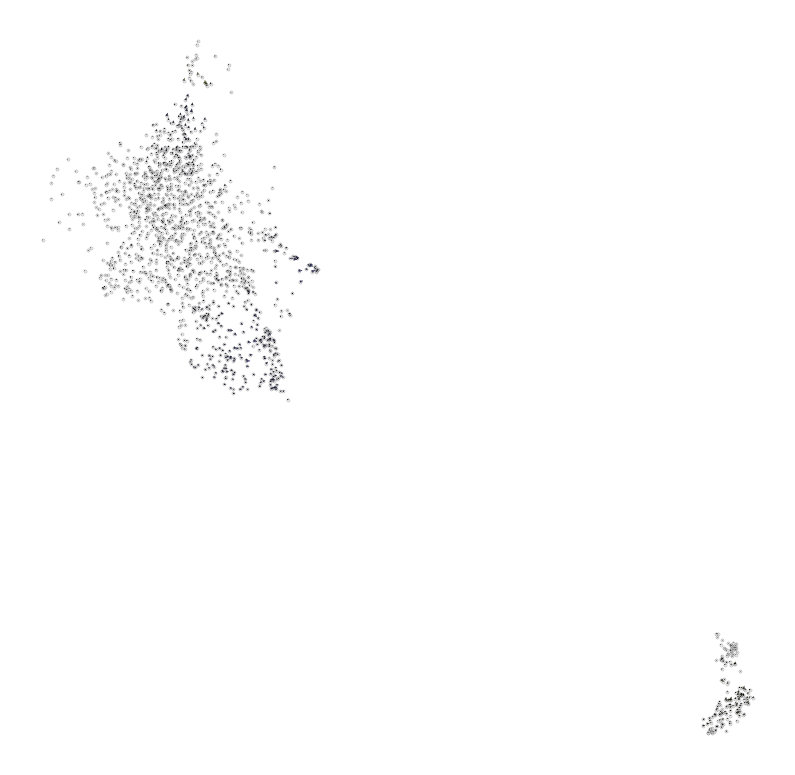

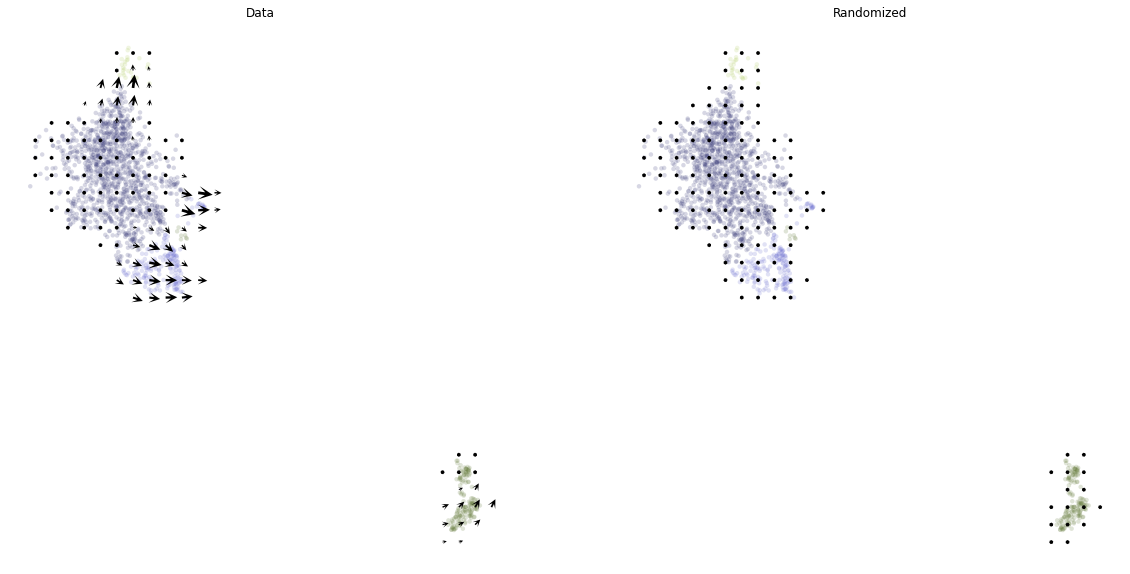

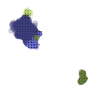

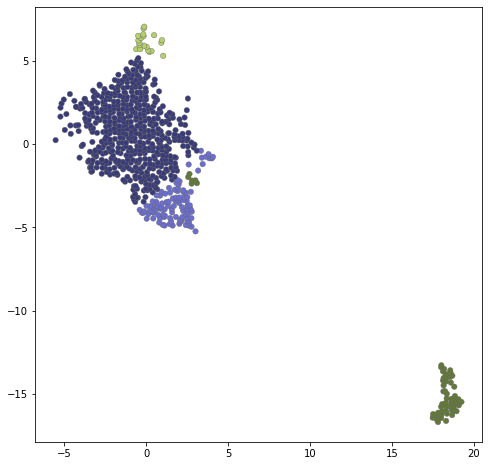

In [16]:
out_dir = "."
sample_id = "bg_corrected_mzb1_v2"

plt.figure(None,(14,14))
quiver_scale = 60
plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")

plt.savefig(os.path.join(out_dir, sample_id + "_full_arrows.pdf"))



plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale="auto",
                     headaxislength=2.75,
                     headlength=5,
                     headwidth=4.8,
                     minlength=1.5,
                     plot_random=True,
                     scale_type="relative")
              #       scatter_kwargs_dict = {'alpha' : 1})

plt.savefig(os.path.join(out_dir, sample_id + "_vectorfield.pdf"))

plt.figure(None,(1.5,1.5))
vlm.plot_grid_arrows(quiver_scale="auto",
                     headaxislength=2.75,
                     headlength=5,
                     headwidth=4.8,
                     minlength=1.5,
                     plot_random=False,
                     scale_type="relative",
                     scatter_kwargs_dict = {'alpha' : 0.2,
                                            's' : 20,
                                            'lw' : 1})
plt.savefig(os.path.join(out_dir, sample_id + "_vectorfield_pub.pdf"), transparent = True)


## Markov Chain analysis

# Sample uniformly the points to avoid density driven effects - Should reimplement as a method
steps = 100, 100
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 1)

diag_step_dist = np.sqrt((meshes_tuple[0][0,0] - meshes_tuple[0][0,1])**2 + (meshes_tuple[1][0,0] - meshes_tuple[1][1,0])**2)
min_dist = diag_step_dist / 2
ixs = ixs[dist < min_dist]
gridpoints_coordinates = gridpoints_coordinates[dist.flat[:]<min_dist,:]
dist = dist[dist < min_dist]

ixs = np.unique(ixs)

plt.figure(None,(8,8))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=vlm.colorandum[ixs], alpha=1, s=30, lw=0.4,
                edgecolor="0.4")



2020-02-13 13:48:41,811 - DEBUG - update_title_pos
2020-02-13 13:48:41,894 - DEBUG - update_title_pos
2020-02-13 13:48:41,921 - DEBUG - update_title_pos
2020-02-13 13:48:41,999 - DEBUG - update_title_pos
2020-02-13 13:48:42,662 - DEBUG - update_title_pos
2020-02-13 13:48:42,738 - DEBUG - update_title_pos
2020-02-13 13:48:42,764 - DEBUG - update_title_pos
2020-02-13 13:48:42,851 - DEBUG - update_title_pos
2020-02-13 13:48:42,880 - DEBUG - update_title_pos
2020-02-13 13:48:42,911 - DEBUG - update_title_pos
2020-02-13 13:48:42,937 - DEBUG - update_title_pos
2020-02-13 13:48:42,950 - DEBUG - update_title_pos


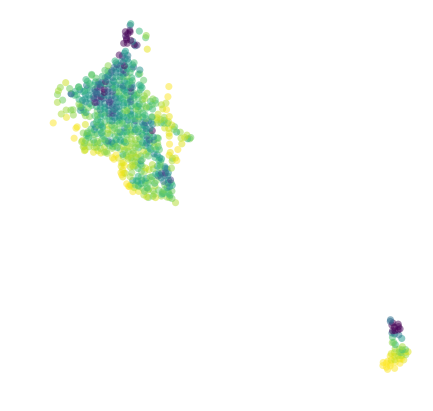

2020-02-13 13:48:42,998 - DEBUG - update_title_pos
2020-02-13 13:48:43,033 - DEBUG - update_title_pos
2020-02-13 13:48:43,064 - DEBUG - update_title_pos
2020-02-13 13:48:43,077 - DEBUG - update_title_pos


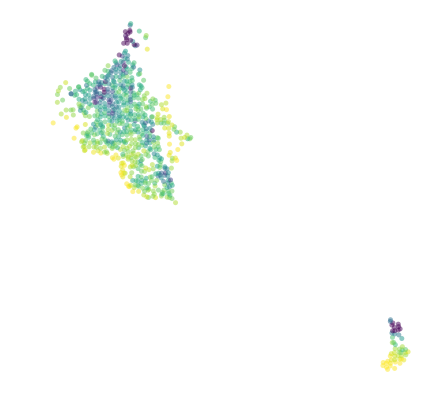

2020-02-13 13:48:43,116 - DEBUG - update_title_pos
2020-02-13 13:48:43,152 - DEBUG - update_title_pos
2020-02-13 13:48:43,179 - DEBUG - update_title_pos
2020-02-13 13:48:43,193 - DEBUG - update_title_pos


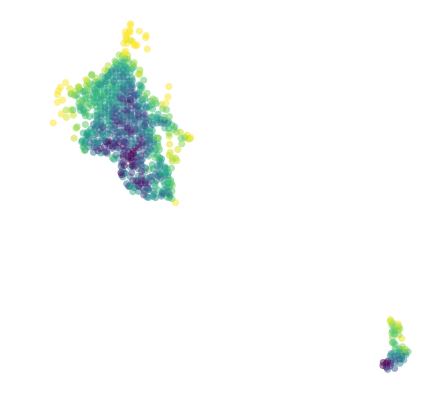

2020-02-13 13:48:43,231 - DEBUG - update_title_pos
2020-02-13 13:48:43,266 - DEBUG - update_title_pos
2020-02-13 13:48:43,295 - DEBUG - update_title_pos
2020-02-13 13:48:43,307 - DEBUG - update_title_pos


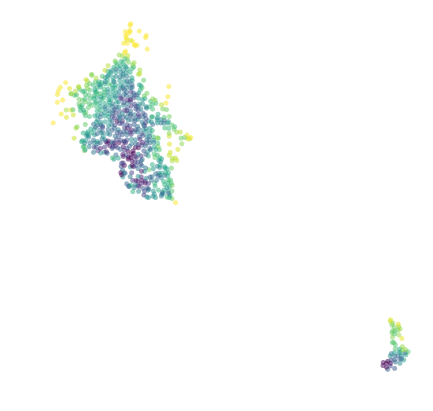

In [11]:
nsteps = 500
sample_id = "short_diffusion_0.5k"
vlm.prepare_markov(sigma_D=diag_step_dist,
                   sigma_W=diag_step_dist/2.,
                   direction='forward', cells_ixs=ixs)

vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps= nsteps)


diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_endpoint_distr.pdf"))


plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=25, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_endpoint_distr_pub.pdf"), transparent = True)

out_df = pd.DataFrame({"CellID" : vlm.ca["CellID"][ixs],
                       "endpoints" : diffused_n})


vlm.prepare_markov(sigma_D=diag_step_dist,
                   sigma_W=diag_step_dist/2.,
                   direction='backwards', cells_ixs=ixs)
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps= nsteps)

diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_startpoint_distr.pdf"))

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=25, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_startpoint_distr_pub.pdf"), transparent = True)


out_df["startpoints"] = diffused_n

out_df.to_csv(os.path.join(out_dir, sample_id + "_markov_points.tsv"),  sep = "\t", index = False)

 